## Is it a llama or an alpaca?

While progressing through the FastAI course, I felt the need for a practical exercise to apply what I was learning. I decided to build an image classification model using neural networks to distinguish between alpacas and llamas. The interesting challenge here is that these two species look remarkably alike! Through this project, I’m not only deepening my understanding of data science techniques but also gaining fascinating insights about these animals!

# Step 0: Basic Configs

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")


In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00:00:0100:01


## Step 1: Download images of llamas and alpacas
The first step in building a classification model is gathering a good dataset. Since llamas and alpacas look quite similar, having diverse and representative images is essential for training a model that can accurately tell them apart.

Considered using duckduckgo_search, as a tool that will help in the automated download process.

In [3]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('llama photos', max_images=5)
urls[3]

'https://wallpaperaccess.com/full/1122420.jpg'

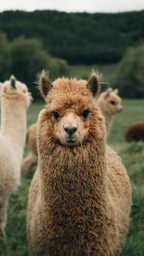

In [5]:
from fastdownload import download_url
dest = 'llama.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

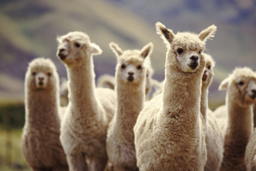

In [6]:
download_url(search_images('alpaca photos', max_images=1)[0], 'alpaca.jpg', show_progress=False)
Image.open('alpaca.jpg').to_thumb(256,256)

In [7]:
searches = 'llama','alpaca'
path = Path('llama_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

With a cleaned and organized dataset of llama and alpaca images ready, the next step is to build and train an image classification model. For this, we’ll use the FastAI library, which simplifies training deep learning models with powerful abstractions.

One thing that I found curious was the technique that Jeremy explains: train your model first and clean it later. In this way, the model can help finding problems with the help of outher resources such as a Confusion Matrix or the analysis of top losses.

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

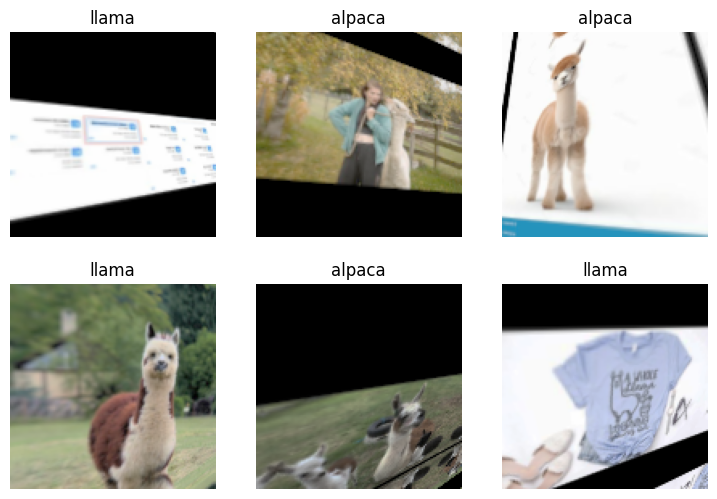

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128, ResizeMethod.Pad, pad_mode='zeros')],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Used Resize Method Pad, so there isn't any loss in the image details. Aug_transforms can give augmented perspective in the images, but I'll need to study more regarding these images functionalities as I believe there's still field to have better graphics to insert to the dataset.

In [10]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.414010,1.591538,0.317460,00:18


epoch,train_loss,valid_loss,error_rate,time
0,1.215055,0.818904,0.349206,00:27
1,1.008387,0.691879,0.285714,00:26
2,0.854098,0.626983,0.253968,00:26


The results show an error_rate of +20%, while running through 3 epochs (I should run for more). This is not a trivial exercise, so it's not something unusual. Nevertheless, we'll try to predict if it's a llama or not, considering the image that we saved first.

In [11]:
is_llama,_,probs = learn.predict(PILImage.create('llama.jpg'))
print(f"This is a: {is_llama}.")
print(f"Probability it's a llama: {probs[0]:.4f}")

This is a: llama.
Probability it's a llama: 0.0046


It guesses it's a llama, with very low confidence

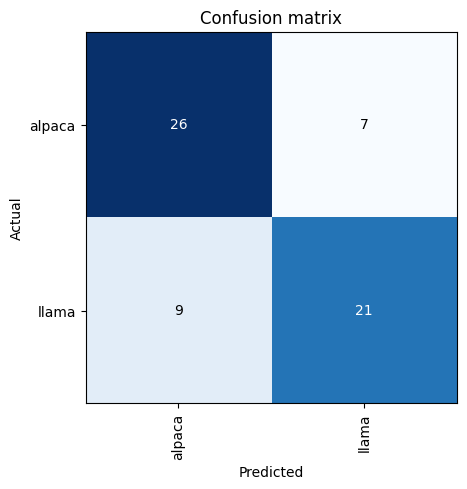

In [12]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion Matrix gives conclusions that valid / train model ratio is doing well. Let's see it by the top losses, where we can understand what are the inferences that the model is actually doing.

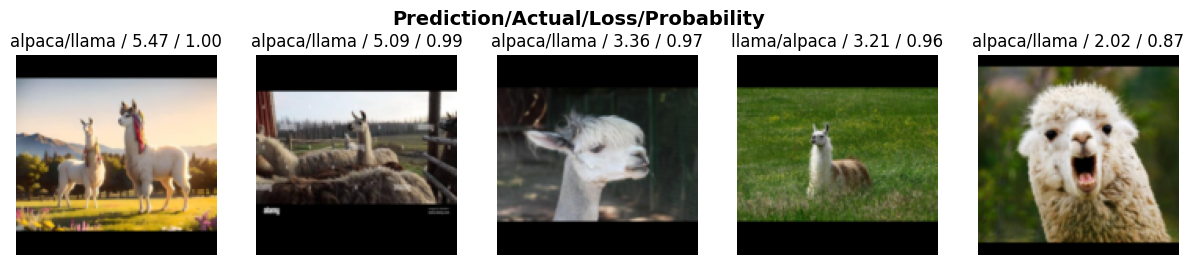

In [13]:
interp.plot_top_losses(5, nrows=1)

The model has having some issues with the actuals. Some photographs of the training dataset are mixed up. We can use the FastAi's vision widget ImageClassifierCleaner to help us doing some data cleaning.

In [14]:
from fastai.vision.widgets import *
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # same split but now on cleaned data
    get_y=parent_label,
    item_tfms=[Resize(128, ResizeMethod.Pad, pad_mode='zeros')],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=32)

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.172732,0.540727,0.229508,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.762773,0.413627,0.213115,00:40
1,0.800704,0.632241,0.278689,00:39
2,0.746931,0.621938,0.262295,00:39
3,0.680654,0.691120,0.245902,00:39
4,0.647940,0.679624,0.229508,00:39


In [19]:
is_llama,_,probs = learn.predict(PILImage.create('llama.jpg'))
print(f"This is a: {is_llama}.")
print(f"Probability it's a llama: {probs[0]:.4f}")

This is a: llama.
Probability it's a llama: 0.0527


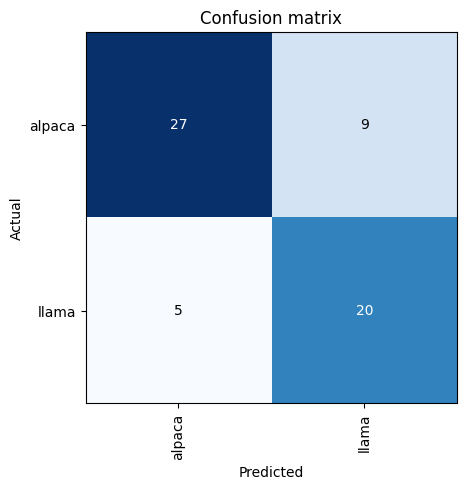

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Step 4: Exporting the Model

In [21]:
learn.export()

In [22]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]